In [ ]:
!pip install transformers -q
!pip install evaluate -q
!pip install datasets -q
!pip install rouge_score -q

  Preparing metadata (setup.py) ... done


In [ ]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
dataset_id= "billsum"
split= "ca_test"

from datasets import load_dataset
billsum = load_dataset(dataset_id, split=f"{split}[:1000]")
billsum = billsum.train_test_split(shuffle=True, test_size=0.2)
# billsum["train"].to_json("billsum_train.jsonl")
# billsum["test"].to_json("billsum_test.jsonl")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2391388

In [ ]:
billsum

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 200
    })
})

# Load model and tokenizer

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
tokenizer.padding_side, tokenizer.eos_token, tokenizer.vocab_size

('right', '</s>', 32100)

# Data Preprrocessing

In [ ]:
billsum

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 200
    })
})

max tokens length text :  5030
min tokens length text :  940


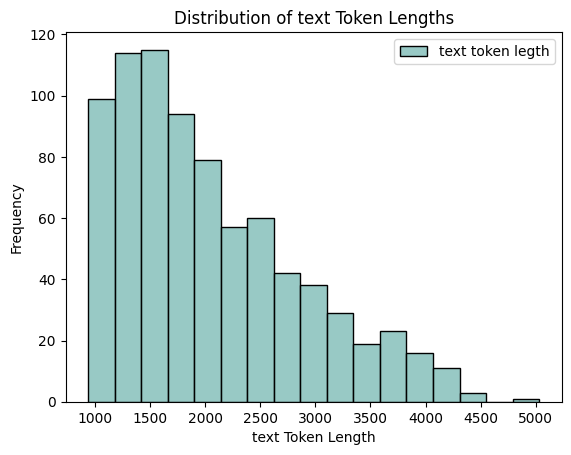

In [ ]:
## for text
max_len_text= []
for key in billsum["train"]:
    tokens= tokenizer(key['text'])
    max_len_text.append(len(tokens['input_ids']))

# colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']
# colors2 = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']


print("max tokens length text : ", max(max_len_text))
print("min tokens length text : ", min(max_len_text))


sns.histplot(max_len_text, color='#76B7B2', label="text token legth")
plt.xlabel("text Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of text Token Lengths")
plt.legend()
plt.show()

max tokens length lbels :  2181
min tokens length lbels :  45


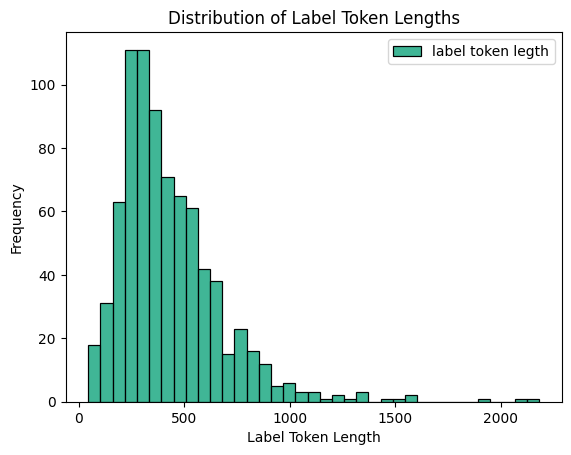

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

max_len_labels= []
for key in billsum["train"]:
    tokens= tokenizer(text_target=key['summary'])
    max_len_labels.append(len(tokens['input_ids']))

print("max tokens length lbels : ", max(max_len_labels))
print("min tokens length lbels : ", min(max_len_labels))


colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']
colors2 = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

sns.histplot(max_len_labels, color=colors2[2], label="label token legth")
plt.xlabel("Label Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Label Token Lengths")
plt.legend()
plt.show()


In [ ]:
# tokens= tokenizer(text_target=billsum['train'][0:2]['summary'], max_length=128, truncation=True)

In [ ]:
def pre_process(sample):
    prefix= "summarize: "
    inputs= [prefix + text for text in sample["text"]]
    model_inputs= tokenizer(inputs, max_length= 1024, truncation= True)
    labels= tokenizer(text_target= sample['summary'], max_length=128, truncation=True) #will keep only 128 tokens in op
    model_inputs["labels"]= labels["input_ids"]
    return model_inputs


## prrocess the data
tokenized_dataset= billsum.map(pre_process, batched=True)
tokenized_dataset


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
})

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
# data_collator

In [ ]:
import evaluate
rouge = evaluate.load("rouge")
# rouge

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True) # decode the predictions
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) #decode the labels (original)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

# Trainings

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_billsum_model",
    eval_strategy="epoch", #evaluate model based on epochs
    learning_rate=2e-5,    #how fast will gradients updates
    per_device_train_batch_size=16, #per device batch size (16 data will pass in 1 step)
    per_device_eval_batch_size=16,  #per device batch size (16 data will pass in 1 step) -  validation
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,                 #run it for 4 epochs
    predict_with_generate=True,
    fp16=True,                          #change to bf16=True for XPU
    push_to_hub=True,                   #push model to the hub (True/False)
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.455433,0.148400,0.049900,0.121100,0.121300,20.000000
2,No log,2.399501,0.176400,0.071700,0.146000,0.146100,20.000000
3,No log,2.357324,0.197800,0.087700,0.165500,0.165600,20.000000
4,No log,2.332458,0.203600,0.093700,0.170000,0.170000,20.000000
5,No log,2.313647,0.206100,0.095300,0.172800,0.172700,20.000000
6,No log,2.298661,0.205600,0.096000,0.172500,0.172400,20.000000
7,No log,2.289807,0.204000,0.095700,0.171400,0.171500,20.000000
8,No log,2.282382,0.204700,0.096200,0.172100,0.172100,20.000000
9,No log,2.278786,0.205300,0.096800,0.172300,0.172300,20.000000
10,2.589600,2.277198,0.205100,0.096800,0.172200,0.172200,20.000000


TrainOutput(global_step=500, training_loss=2.58961767578125, metrics={'train_runtime': 569.9895, 'train_samples_per_second': 14.035, 'train_steps_per_second': 0.877, 'total_flos': 2165468823552000.0, 'train_loss': 2.58961767578125, 'epoch': 10.0})

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1744996503.2adfca683a6a.656.1:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Shubhu07/my_billsum_model/commit/97beb604dbe39c45ce9bd2a88b3bffcd4f2d1b7b', commit_message='End of training', commit_description='', oid='97beb604dbe39c45ce9bd2a88b3bffcd4f2d1b7b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Shubhu07/my_billsum_model', endpoint='https://huggingface.co', repo_type='model', repo_id='Shubhu07/my_billsum_model'), pr_revision=None, pr_num=None)

In [ ]:
billsum['train'][0]['text']

'The people of the State of California do enact as follows:\n\n\nSECTION 1.\nSection 23102 of the\nRevenue and Taxation Code\nis amended to read:\n23102.\nAny corporation or limited liability company holding or organized to hold stock or bonds of any other corporation or corporations, and not trading in stock or bonds or other securities held, and engaging in no activities other than the receipt and disbursement of dividends from stock or interest from bonds, and no activities other than those exempted under subdivision (c) of Section 191 of the Corporations Code, is not a corporation or limited liability company doing business in this State for the purposes of this chapter or Chapter 10.6.\nSECTION 1.\nSection 17941 of the Revenue and Taxation Code is amended to read:\n17941.\n(a) For each taxable year beginning on or after January 1, 1997, a limited liability company doing business in this\nstate (as\nstate, as\ndefined in Section\n23101)\n23101,\nshall pay annually to this state a t

In [ ]:
from transformers import AutoTokenizer
text=billsum['train'][0]['text']
tokenizer = AutoTokenizer.from_pretrained("Shubhu07/my_billsum_model")
inputs = tokenizer(text, return_tensors="pt").input_ids

Token indices sequence length is longer than the specified maximum sequence length for this model (1501 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("Shubhu07/my_billsum_model")
outputs = model.generate(inputs, max_new_tokens=100, do_sample=False)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
billsum['train'][0]['summary']

'Existing\nlaw,\nlaw\nimposes a minimum franchise tax of $800, except as provided, on every corporation incorporated in this state, qualified to transact intrastate business in this state, or doing business, as defined, in this state, and an annual tax in an amount equal to the minimum franchise tax on every limited liability company registered, qualified to transact business, or doing business in this state, as specified.\nExisting law provides that certain corporations, the activities of which are limited to the receipt and disbursement of dividends and interest on securities, are not considered as doing business in this state.\nExisting law requires every limited liability company subject to that annual tax to pay annually to this state a fee equal to specified amounts based upon total income from all sources attributable to this state. Existing law requires every partnership to file a return that includes specified information, verified by a written declaration made under the penal